# Post-Processing (General)

#### Updated: May 17, 2023

#  

Post-processing pipeline after stage 2 of Alouette processing (OCR processing stage):

In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns

In [2]:
rootDir = 'L:/DATA/Alouette_I/BATCH_II_Run2/'
processedDir = rootDir + '04_processed/'
resultDir = rootDir + '05_result/'
logDir = rootDir + '06_log/'

#  

#### Functions:

In [3]:
def construct_timestamp(df_in):
    
    df_in['time_quality'] = 0
    
    #To the nearest second (time quality 1)
    df_in['month_day'] = pd.to_datetime(df_in['day_of_year'], format='%j').dt.strftime('%m-%d')
    df_in['month'] = df_in['month_day'].str.split('-').str[0]
    df_in['day'] = df_in['month_day'].str.split('-').str[1]
    df_in['Timestamp'] = pd.to_datetime(df_in[['year', 'month', 'day', 'hour', 'minute', 'second']], format='%Y-%m-%d %H:%M:%S')
    df_in.loc[~df_in['Timestamp'].isnull(), 'time_quality'] = 1
    df_in_tq1 = df_in.loc[df_in['time_quality'] == 1]
    
    #To the nearest minute (time quality 2)
    df_in_not_tq1 = df_in.loc[df_in['time_quality'] != 1]
    df_in_not_tq1 = df_in_not_tq1.copy(deep=True)
    df_in_not_tq1['Timestamp'] = pd.to_datetime(df_in_not_tq1[['year', 'month', 'day', 'hour', 'minute']], format='%Y-%m-%d %H:%M:00')
    df_in_not_tq1.loc[~df_in_not_tq1['Timestamp'].isnull(), 'time_quality'] = 2
    df_in_tq2 = df_in_not_tq1.loc[df_in_not_tq1['time_quality'] == 2]
    
    #To the nearest hour (time quality 3)
    df_in_not_tq2 = df_in_not_tq1.loc[df_in_not_tq1['time_quality'] != 2]
    df_in_not_tq2 = df_in_not_tq2.copy(deep=True)
    df_in_not_tq2['Timestamp'] = pd.to_datetime(df_in_not_tq2[['year', 'month', 'day', 'hour']], format='%Y-%m-%d %H:00:00')
    df_in_not_tq2.loc[~df_in_not_tq2['Timestamp'].isnull(), 'time_quality'] = 3
    df_in_tq3 = df_in_not_tq2.loc[df_in_not_tq2['time_quality'] == 3]
    
    #To the nearest day (time quality 4)
    df_in_not_tq3 = df_in_not_tq2.loc[df_in_not_tq2['time_quality'] != 3]
    df_in_not_tq3 = df_in_not_tq3.copy(deep=True)
    df_in_not_tq3['Timestamp'] = pd.to_datetime(df_in_not_tq3[['year', 'month', 'day']], format='%Y-%m-%d 00:00:00')
    df_in_not_tq3.loc[~df_in_not_tq3['Timestamp'].isnull(), 'time_quality'] = 4
    df_in_tq4 = df_in_not_tq3.loc[df_in_not_tq3['time_quality'] == 4]
    
    df_in_not_tq4 = df_in_not_tq3.loc[df_in_not_tq3['time_quality'] != 4]
    df_in = pd.concat([df_in_tq1, df_in_tq2, df_in_tq3, df_in_tq4, df_in_not_tq4])
    
    return df_in

#  

#### Generate processed_inventory, concatenate stage 1 results - RUN BEFORE starting stage 2 processing (OCR processing stage):

Generate processed_inventory:

In [ ]:
df_inventory = pd.DataFrame()
for directory in os.listdir(processedDir):
    print(directory)
    for subdirectory in os.listdir(processedDir + directory):
        n_images = len(os.listdir(processedDir + directory + '/' + subdirectory))
        df_inventory_ = pd.DataFrame({
            'Directory': directory, 
            'Subdirectory': subdirectory,
            'images': n_images,
            'subdir_id': directory + '_' + subdirectory
        }, index=[0])
        df_inventory = pd.concat([df_inventory, df_inventory_], axis=0, ignore_index=True)

In [ ]:
print(len(df_inventory))
df_inventory.head()

In [ ]:
df_inventory.to_csv(logDir + 'image_inventory_processed.csv', index=False)

Concatenate stage 1 results:

In [ ]:
df_result = pd.DataFrame()
i = 0
for file in os.listdir(resultDir):
    if 'R' in file:
        directory = file
        for file2 in os.listdir(resultDir + directory + '/'):
            if 'result-' in file2:
                fn_parts = file2.split('_')
                subdirectory = fn_parts[1].replace('.csv', '')
                if i > 0:
                    if i % 100 == 0:
                        df_result = pd.read_csv(resultDir + 'result_stage1_raw.csv')
                        print(len(df_result))
                try:
                    df_load = pd.read_csv(resultDir + directory + '/' + file2, sep=',')
                    n = len(df_load)
                except pd.errors.EmptyDataError:
                    n = 0
                    df_load = pd.DataFrame()
                df_result = pd.concat([df_result, df_load])
                i += 1
                if i % 100 == 0:
                    print('Now saving the ' + str(i) + 'th result...')
                    df_result.to_csv(resultDir + 'result_stage1_raw.csv', index=False)
df_result.to_csv(resultDir + 'result_stage1_raw.csv', index=False)

In [ ]:
df_result = pd.read_csv(resultDir + 'result_stage1_raw.csv')
print(len(df_result))
df_result.sample(10)

#  

#### Concatenate 'OCR pass' results - START HERE after stage 2 processeing (OCR processing stage):

In [4]:
df_result = pd.DataFrame()
i = 0
for file in os.listdir(resultDir):
    if 'R' in file:
        directory = file
        for file2 in os.listdir(resultDir + directory + '/'):
            if 'result_OCRpass' in file2:
                fn_parts = file2.split('_')
                subdirectory = fn_parts[2].replace('.csv', '')
                if i > 0:
                    if i % 100 == 0:
                        df_result = pd.read_csv(resultDir + 'result_stage2_raw.csv', low_memory=False)
                        print(len(df_result))
                try:
                    df_load = pd.read_csv(resultDir + directory + '/' + file2, sep=',')
                    n = len(df_load)
                except pd.errors.EmptyDataError:
                    n = 0
                df_result = pd.concat([df_result, df_load])
                i += 1
                if i % 100 == 0:
                    print('Now saving the ' + str(i) + 'th result...')
                    df_result.to_csv(resultDir + 'result_stage2_raw.csv', index=False)
df_result.to_csv(resultDir + 'result_stage2_raw.csv', index=False)

Now saving the 100th result...
29419
Now saving the 200th result...
58012
Now saving the 300th result...
86791
Now saving the 400th result...
114342


#  

#### Reduce columns:

In [5]:
df_result = pd.read_csv(resultDir + 'result_stage2_raw.csv', low_memory=False)
print(len(df_result))
df_result.head()

126332


,fmin,max_depth,satellite_number,year,day_1,day_2,day_3,hour_1,hour_2,minute_1,...,Subdirectory,filename,station_code,station_number,station_number_OCR,year_OCR,day_of_year_OCR,hour_OCR,minute_OCR,second_OCR
0,1.500000,1443.396226,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,24,191.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.504032,405.660377,0.0,0.0,2.0,0.0,1.0,1.0,1.0,0.0,...,24,218.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.500000,1537.735849,1.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,...,24,33.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9.650538,1490.566038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,24,83.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,24,1.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_result['year_1'] = df_result['year']
df_result = df_result[['Directory', 'Subdirectory', 'filename', 'processed_image_class', 'fmin', 'max_depth', 
                       'station_number', 'station_number_1', 'station_number_2', 'year_1', 'day_1', 'day_2', 'day_3', 
                       'hour_1', 'hour_2', 'minute_1', 'minute_2', 'second_1', 'second_2', 'satellite_number', 
                       'station_number_OCR', 'year_OCR', 'day_of_year_OCR', 'hour_OCR', 'minute_OCR', 'second_OCR', 
                       'metadata_type', 'is_dot', 'func_name', 'details']] 
df_result.sample(10)

,Directory,Subdirectory,filename,processed_image_class,fmin,max_depth,station_number,station_number_1,station_number_2,year_1,...,station_number_OCR,year_OCR,day_of_year_OCR,hour_OCR,minute_OCR,second_OCR,metadata_type,is_dot,func_name,details
1629,R014207711,61,9.png,outlier,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,image_segmentation.segment_images_in_subdir.se...,"height: 663,width: 2228"
7771,R014207808,4612-50,103.png,loss,1.677419,1256.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,metadata could not be read by OCR
7632,R014207808,4607-15,266.png,loss,4.814815,1356.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,metadata could not be read by OCR
69022,R014207835,4056-19,17.png,num2,1.620968,1396.969697,NaN,NaN,NaN,NaN,...,19.0,61.0,044,05,53,24,NaN,NaN,NaN,NaN
102294,R014207950,2489-8-A,37.png,outlier,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,image_segmentation.segment_images_in_subdir.se...,"height: 761,width: 2147"
78011,R014207838,4512-43A,53.png,num,1.883065,1373.469388,NaN,2.0,3.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10239,R014207810,5125,200.png,outlier,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,image_segmentation.segment_images_in_subdir.se...,"height: 871,width: 4221"
50157,R014207828,4440-50,3.png,loss,1.544355,953.061224,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,metadata could not be read by OCR
44661,R014207827,3790-13A,12.png,loss,1.500000,1376.595745,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,metadata could not be read by OCR
60348,R014207831,3942-43A,73.png,loss,1.653226,1402.173913,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,metadata could not be read by OCR


#  

#### Split results into different metadata types (dot, num, num2):

In [7]:
df_result['processed_image_class'].unique()

array(['num', 'loss', 'outlier', 'dot', 'num2'], dtype=object)

In [8]:
df_num2 = df_result.loc[df_result['processed_image_class'] == 'num2']
print(len(df_num2))

20368


In [9]:
df_num = df_result.loc[df_result['processed_image_class'] == 'num']
print(len(df_num))

33178


In [10]:
df_dot = df_result.loc[df_result['processed_image_class'] == 'dot']
print(len(df_dot))

2042


In [11]:
df_outlier = df_result.loc[df_result['processed_image_class'] == 'outlier']
print(len(df_outlier))

12253


In [12]:
df_loss = df_result.loc[df_result['processed_image_class'] == 'loss']
print(len(df_loss))

58491


In [13]:
len(df_num2) + len(df_num) + len(df_dot) + len(df_outlier) + len(df_loss)

126332

#### num2 - check timestamp components, construct timestamp:

In [14]:
df_num2[['year_OCR', 'day_of_year_OCR', 'hour_OCR', 'minute_OCR', 'second_OCR']].sample(10)

,year_OCR,day_of_year_OCR,hour_OCR,minute_OCR,second_OCR
68807,67,125.0,14,8.0,45.0
44845,66,243,1.0,65.0,64
63716,68.0,108,12.0,48.0,22
59929,67.0,109.0,18.0,04,10
60047,67.0,107.0,23.0,58,57
63296,67.0,255.0,13.0,36.0,43
65906,68.0,084,2.0,9.0,18.0
25348,61,186.0,15.0,44,18
39757,66.0,304.0,20,3.0,22.0
59553,67.0,095,18,12,24


year:

<Axes: xlabel='year_OCR', ylabel='Count'>

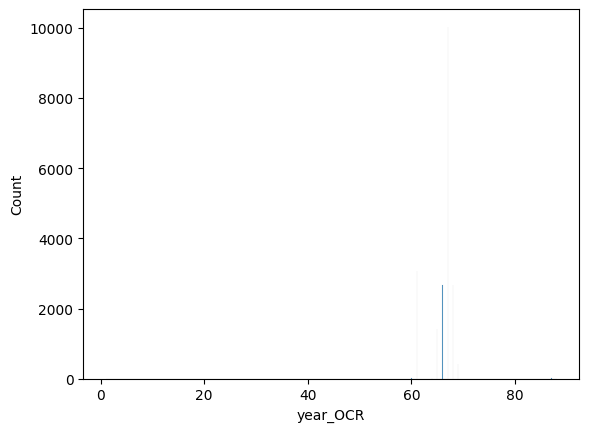

In [15]:
df_num2 = df_num2.copy(deep=True)
df_num2['year_OCR'] = df_num2['year_OCR'].astype('float')
sns.histplot(data=df_num2, x='year_OCR')

In [16]:
df_num2['year_OCR'] = df_num2['year_OCR'].apply(lambda x: np.nan if x<62 else x)
df_num2['year_OCR'] = df_num2['year_OCR'].apply(lambda x: np.nan if x>80 else x)

In [17]:
df_num2['year'] = df_num2['year_OCR'] + 1900
df_num2[['year', 'year_OCR']].sample(10)

,year,year_OCR
66187,1968.0,68.0
22279,NaN,NaN
22646,1967.0,67.0
24263,1967.0,67.0
67693,1965.0,65.0
62069,1967.0,67.0
81125,NaN,NaN
65916,1968.0,68.0
24423,1967.0,67.0
25914,NaN,NaN


day:

<Axes: xlabel='day_of_year_OCR', ylabel='Count'>

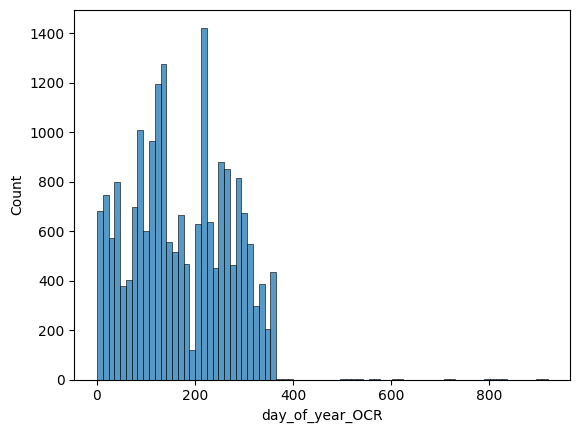

In [18]:
df_num2['day_of_year_OCR'] = df_num2['day_of_year_OCR'].astype('float')
sns.histplot(data=df_num2, x='day_of_year_OCR')

In [19]:
df_num2['day_of_year_OCR'] = df_num2['day_of_year_OCR'].apply(lambda x: np.nan if x>366 else x)
df_num2['day_of_year_OCR'] = df_num2['day_of_year_OCR'].apply(lambda x: np.nan if x==0 else x)
df_num2['day_of_year'] = df_num2['day_of_year_OCR']
df_num2[['day_of_year', 'day_of_year_OCR']].sample(10)

,day_of_year,day_of_year_OCR
42502,213.0,213.0
22730,206.0,206.0
75943,167.0,167.0
39855,305.0,305.0
83305,210.0,210.0
46198,326.0,326.0
68271,27.0,27.0
7913,292.0,292.0
69140,49.0,49.0
26113,91.0,91.0


hour:

<Axes: xlabel='hour_OCR', ylabel='Count'>

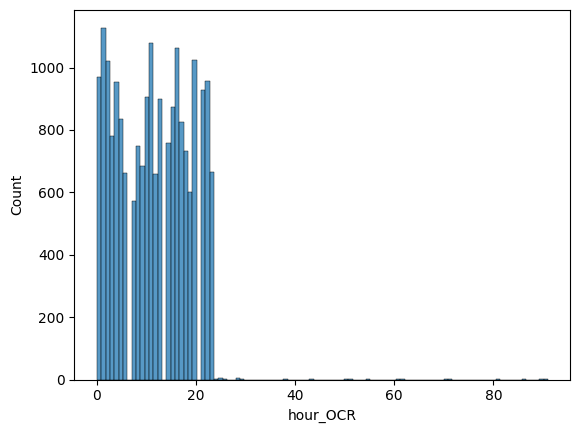

In [20]:
df_num2['hour_OCR'] = df_num2['hour_OCR'].astype('float')
sns.histplot(data=df_num2, x='hour_OCR')

In [21]:
df_num2['hour_OCR'] = df_num2['hour_OCR'].apply(lambda x: np.nan if x>24 else x)
df_num2['hour'] = df_num2['hour_OCR']
df_num2[['hour', 'hour_OCR']].sample(10)

,hour,hour_OCR
60417,20.0,20.0
58682,18.0,18.0
22437,6.0,6.0
25031,17.0,17.0
24791,0.0,0.0
83796,22.0,22.0
68391,1.0,1.0
25117,21.0,21.0
64358,15.0,15.0
81580,7.0,7.0


minute:

<Axes: xlabel='minute_OCR', ylabel='Count'>

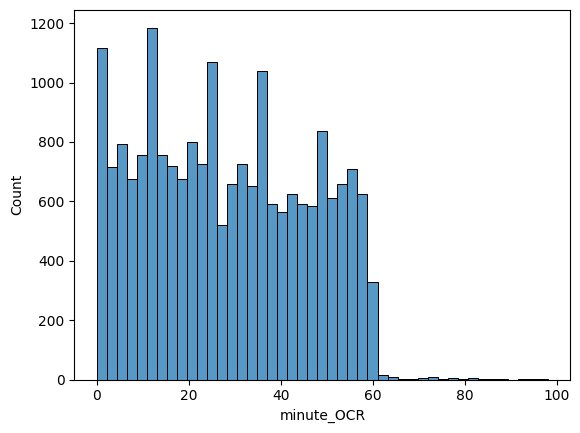

In [22]:
df_num2['minute_OCR'] = df_num2['minute_OCR'].astype('float')
sns.histplot(data=df_num2, x='minute_OCR')

In [23]:
df_num2['minute_OCR'] = df_num2['minute_OCR'].apply(lambda x: np.nan if x>60 else x)
df_num2['minute'] = df_num2['minute_OCR']
df_num2[['minute', 'minute_OCR']].sample(10)

,minute,minute_OCR
60868,4.0,4.0
21619,59.0,59.0
25577,44.0,44.0
82393,6.0,6.0
59840,37.0,37.0
20857,2.0,2.0
69404,22.0,22.0
48924,5.0,5.0
44860,48.0,48.0
43427,26.0,26.0


second:

<Axes: xlabel='second_OCR', ylabel='Count'>

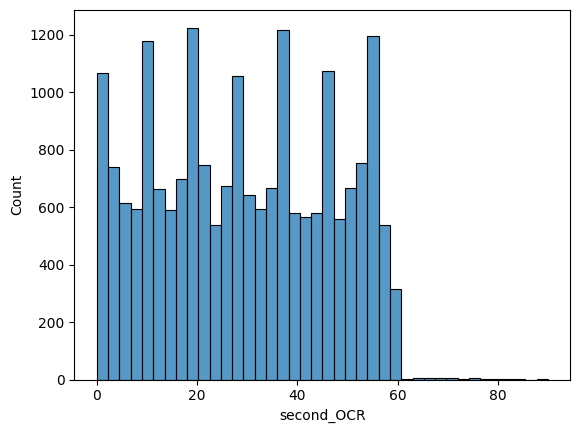

In [24]:
df_num2['second_OCR'] = df_num2['second_OCR'].astype('float')
sns.histplot(data=df_num2, x='second_OCR')

In [25]:
df_num2['second_OCR'] = df_num2['second_OCR'].apply(lambda x: np.nan if x>60 else x)
df_num2['second'] = df_num2['second_OCR']
df_num2[['second', 'second_OCR']].sample(10)

,second,second_OCR
24681,35.0,35.0
59049,20.0,20.0
27424,39.0,39.0
60328,8.0,8.0
21796,46.0,46.0
83224,13.0,13.0
59866,48.0,48.0
42969,51.0,51.0
68708,1.0,1.0
59328,54.0,54.0


construct timestamp:

In [26]:
df_num2 = construct_timestamp(df_in=df_num2)
print(len(df_num2))

20368


In [27]:
df_num2[['year', 'month', 'day', 'hour', 'minute', 'second', 'Timestamp', 'time_quality']].sample(10)

,year,month,day,hour,minute,second,Timestamp,time_quality
6194,1966.0,07,11,1.0,29.0,40.0,1966-07-11 01:29:40,1
59508,1967.0,04,05,2.0,27.0,30.0,1967-04-05 02:27:30,1
67798,1965.0,09,07,0.0,56.0,2.0,1965-09-07 00:56:02,1
8045,1968.0,10,24,0.0,29.0,13.0,1968-10-24 00:29:13,1
68802,1967.0,05,05,14.0,7.0,18.0,1967-05-05 14:07:18,1
82294,1967.0,08,12,22.0,29.0,50.0,1967-08-12 22:29:50,1
82623,1967.0,08,28,20.0,3.0,48.0,1967-08-28 20:03:48,1
81706,NaN,08,14,6.0,27.0,38.0,NaT,0
61414,NaN,06,09,1.0,33.0,51.0,NaT,0
63060,NaN,11,27,4.0,32.0,35.0,NaT,0


#  

#### num - check timestamp components, construct timestamp:

In [28]:
df_num[['year_1', 'day_1', 'day_2', 'day_3', 'hour_1', 'hour_2', 'minute_1', 'minute_2', 'second_1', 'second_2']].sample(10)

,year_1,day_1,day_2,day_3,hour_1,hour_2,minute_1,minute_2,second_1,second_2
119416,3.0,2.0,9.0,0.0,0.0,1.0,3.0,8.0,4.0,3.0
104971,5.0,0.0,9.0,8.0,0.0,2.0,5.0,9.0,1.0,7.0
106799,5.0,1.0,7.0,5.0,1.0,8.0,4.0,4.0,4.0,0.0
94478,4.0,2.0,5.0,5.0,0.0,1.0,0.0,5.0,2.0,2.0
94195,4.0,1.0,8.0,3.0,0.0,9.0,0.0,6.0,0.0,7.0
94965,4.0,2.0,5.0,7.0,0.0,0.0,3.0,2.0,1.0,0.0
113750,0.0,3.0,0.0,0.0,8.0,5.0,8.0,5.0,0.0,0.0
102064,4.0,2.0,1.0,8.0,1.0,2.0,1.0,2.0,0.0,6.0
54925,2.0,2.0,1.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0
92046,4.0,1.0,6.0,8.0,0.0,8.0,3.0,5.0,3.0,7.0


year - adjust to baseline 1962:

<Axes: xlabel='year', ylabel='Count'>

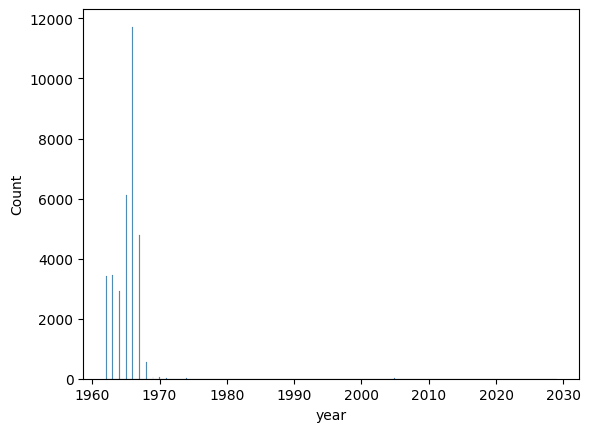

In [29]:
df_num = df_num.copy(deep=True)
df_num['year'] = df_num['year_1'] + 1962
df_num['year'] = df_num['year'].astype('float')
sns.histplot(data=df_num, x='year')

In [30]:
df_num['year'] = df_num['year'].apply(lambda x: np.nan if x<1962 else x)
df_num['year'] = df_num['year'].apply(lambda x: np.nan if x>1980 else x)
df_num[['year', 'year_1']].sample(10)

,year,year_1
91151,1963.0,1.0
115039,1966.0,4.0
112228,1965.0,3.0
91926,1966.0,4.0
120528,1965.0,3.0
100189,1967.0,5.0
102792,1967.0,5.0
34759,1964.0,2.0
117737,1966.0,4.0
112698,1962.0,0.0


day:

<Axes: xlabel='day_1', ylabel='Count'>

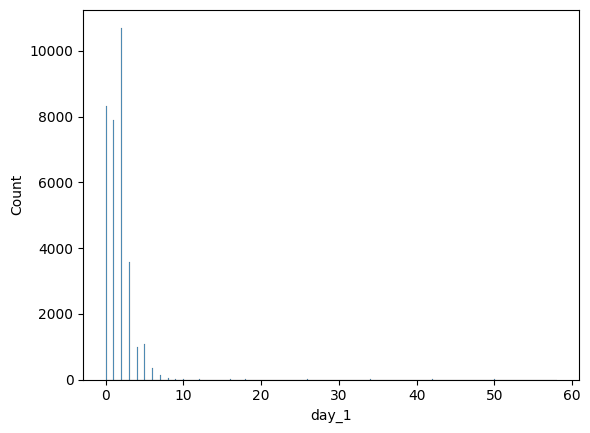

In [31]:
df_num['day_1'] = df_num['day_1'].astype(int)
sns.histplot(data=df_num, x='day_1')

In [32]:
df_num['day_1'] = df_num['day_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='day_2', ylabel='Count'>

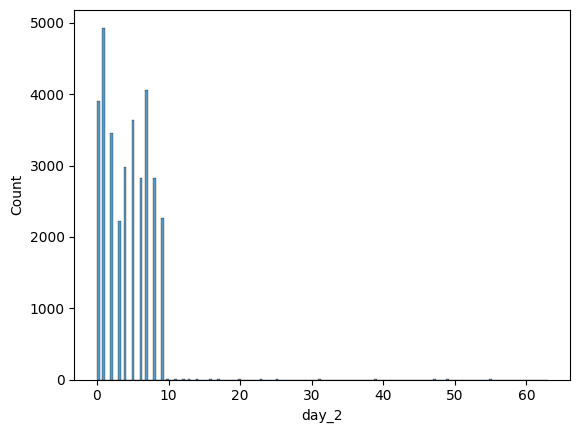

In [33]:
df_num['day_2'] = df_num['day_2'].astype(int)
sns.histplot(data=df_num, x='day_2')

In [34]:
df_num['day_2'] = df_num['day_2'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='day_3', ylabel='Count'>

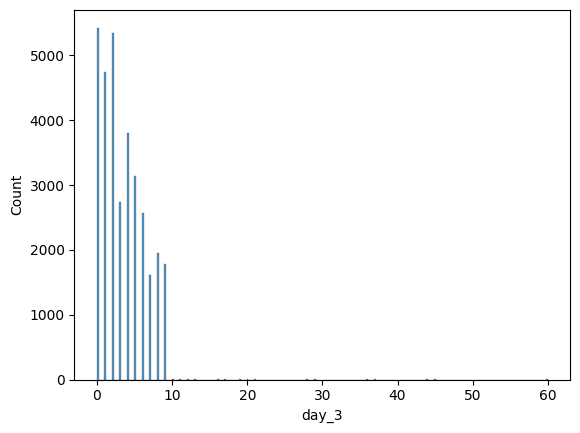

In [35]:
df_num['day_3'] = df_num['day_3'].astype(int)
sns.histplot(data=df_num, x='day_3')

In [36]:
df_num['day_3'] = df_num['day_3'].apply(lambda x: np.nan if x>9 else x)

In [37]:
df_num_daycheck = df_num[~pd.isna(df_num['day_1'])]
df_num_daycheck = df_num_daycheck[~pd.isna(df_num_daycheck['day_2'])]
df_num_daycheck = df_num_daycheck[~pd.isna(df_num_daycheck['day_3'])]
df_num_daycheck['day_of_year'] = df_num_daycheck['day_1'].astype(int).astype(str) + df_num_daycheck['day_2'].astype(int).astype(str) + df_num_daycheck['day_3'].astype(int).astype(str)
df_num_daycheck['day_of_year'] = df_num_daycheck['day_of_year'].astype(int)
df_num_daycheck['day_of_year'] = df_num_daycheck['day_of_year'].apply(lambda x: np.nan if x>366 else x)
df_num_daycheck['day_of_year'] = df_num_daycheck['day_of_year'].apply(lambda x: np.nan if x==0 else x)
df_num_nullday = df_num.loc[pd.isna(df_num['day_1']) | pd.isna(df_num['day_2']) | pd.isna(df_num['day_3'])]
df_num_nullday = df_num_nullday.copy(deep=True)
df_num_nullday['day_of_year'] = np.nan
df_num = pd.concat([df_num_daycheck, df_num_nullday])
print(len(df_num))
df_num[['day_of_year', 'day_1', 'day_2', 'day_3']].sample(10)

33178


,day_of_year,day_1,day_2,day_3
109503,288.0,2.0,8.0,8.0
41756,NaN,4.0,1.0,4.0
44135,NaN,4.0,2.0,2.0
118161,210.0,2.0,1.0,0.0
94533,246.0,2.0,4.0,6.0
92988,166.0,1.0,6.0,6.0
96308,282.0,2.0,8.0,2.0
109439,289.0,2.0,8.0,9.0
96733,276.0,2.0,7.0,6.0
101814,276.0,2.0,7.0,6.0


hour:

<Axes: xlabel='hour_1', ylabel='Count'>

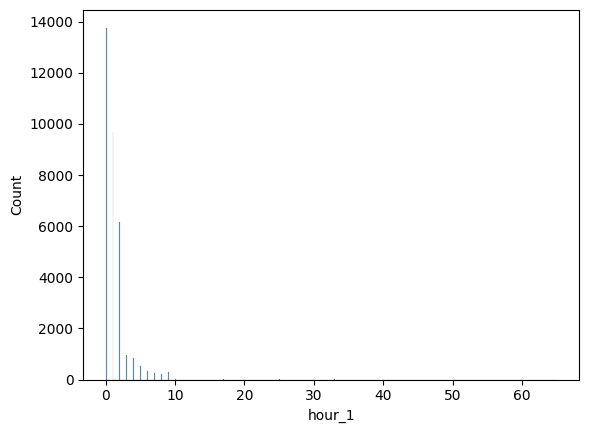

In [38]:
df_num['hour_1'] = df_num['hour_1'].astype(int)
sns.histplot(data=df_num, x='hour_1')

In [39]:
df_num['hour_1'] = df_num['hour_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='hour_2', ylabel='Count'>

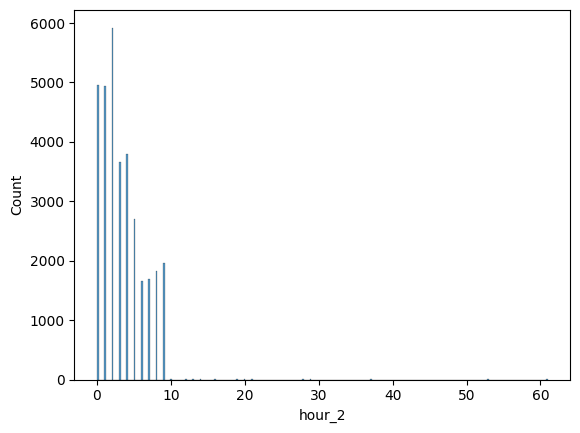

In [40]:
df_num['hour_2'] = df_num['hour_2'].astype(int)
sns.histplot(data=df_num, x='hour_2')

In [41]:
df_num['hour_2'] = df_num['hour_2'].apply(lambda x: np.nan if x>9 else x)

In [42]:
df_num_hourcheck = df_num[~pd.isna(df_num['hour_1'])]
df_num_hourcheck = df_num_hourcheck[~pd.isna(df_num_hourcheck['hour_2'])]
df_num_hourcheck['hour'] = df_num_hourcheck['hour_1'].astype(int).astype(str) + df_num_hourcheck['hour_2'].astype(int).astype(str)
df_num_hourcheck['hour'] = df_num_hourcheck['hour'].astype(int)
df_num_hourcheck['hour'] = df_num_hourcheck['hour'].apply(lambda x: np.nan if x>23 else x)
df_num_nullhour = df_num.loc[pd.isna(df_num['hour_1']) | pd.isna(df_num['hour_2'])]
df_num_nullhour = df_num_nullhour.copy(deep=True)
df_num_nullhour['hour'] = np.nan
df_num = pd.concat([df_num_hourcheck, df_num_nullhour])
print(len(df_num))
df_num[['hour', 'hour_1', 'hour_2']].sample(10)

33178


,hour,hour_1,hour_2
108281,6.0,0.0,6.0
92015,6.0,0.0,6.0
53360,11.0,1.0,1.0
95075,6.0,0.0,6.0
114772,11.0,1.0,1.0
101668,13.0,1.0,3.0
117413,20.0,2.0,0.0
91171,NaN,6.0,0.0
29770,13.0,1.0,3.0
118037,1.0,0.0,1.0


minute:

<Axes: xlabel='minute_1', ylabel='Count'>

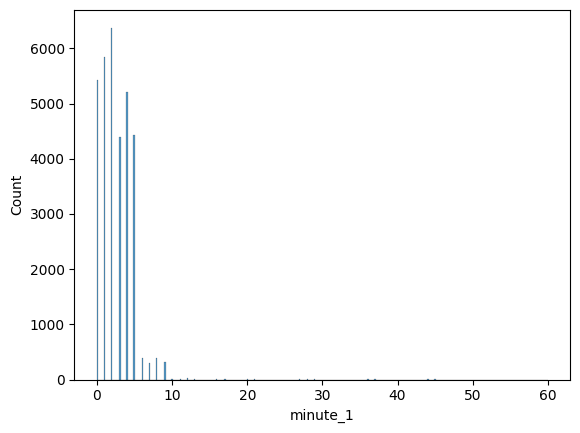

In [43]:
df_num['minute_1'] = df_num['minute_1'].astype(int)
sns.histplot(data=df_num, x='minute_1')

In [44]:
df_num['minute_1'] = df_num['minute_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='minute_2', ylabel='Count'>

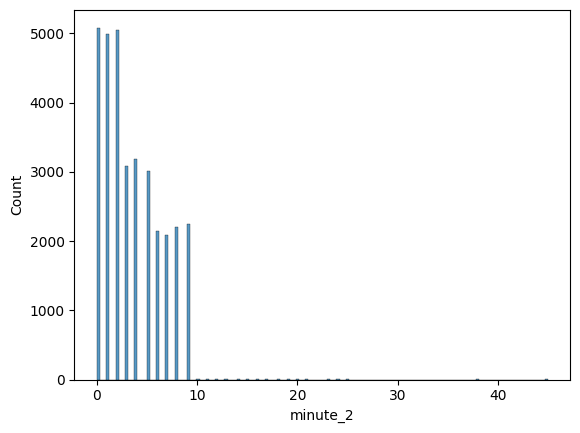

In [45]:
df_num['minute_2'] = df_num['minute_2'].astype(int)
sns.histplot(data=df_num, x='minute_2')

In [46]:
df_num['minute_2'] = df_num['minute_2'].apply(lambda x: np.nan if x>9 else x)

In [47]:
df_num_mincheck = df_num[~pd.isna(df_num['minute_1'])]
df_num_mincheck = df_num_mincheck[~pd.isna(df_num_mincheck['minute_2'])]
df_num_mincheck['minute'] = df_num_mincheck['minute_1'].astype(int).astype(str) + df_num_mincheck['minute_2'].astype(int).astype(str)
df_num_mincheck['minute'] = df_num_mincheck['minute'].astype(int)
df_num_mincheck['minute'] = df_num_mincheck['minute'].apply(lambda x: np.nan if x>59 else x)
df_num_nullmin = df_num.loc[pd.isna(df_num['minute_1']) | pd.isna(df_num['minute_2'])]
df_num_nullmin = df_num_nullmin.copy(deep=True)
df_num_nullmin['minute'] = np.nan
df_num = pd.concat([df_num_mincheck, df_num_nullmin])
print(len(df_num))
df_num[['minute', 'minute_1', 'minute_2']].sample(10)

33178


,minute,minute_1,minute_2
99117,25.0,2.0,5.0
110658,22.0,2.0,2.0
99136,47.0,4.0,7.0
115606,29.0,2.0,9.0
97151,42.0,4.0,2.0
113186,23.0,2.0,3.0
118315,8.0,0.0,8.0
97550,32.0,3.0,2.0
93180,24.0,2.0,4.0
105465,21.0,2.0,1.0


second:

<Axes: xlabel='second_1', ylabel='Count'>

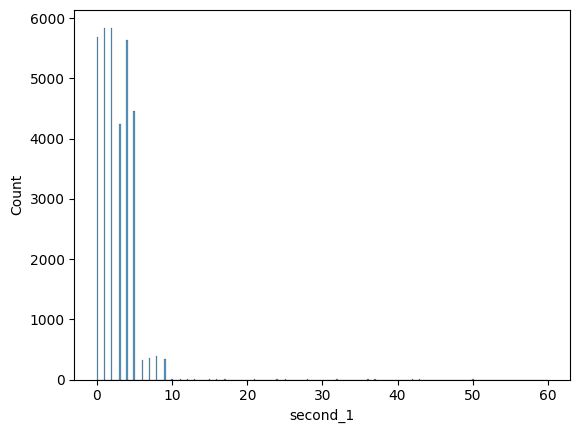

In [48]:
df_num['second_1'] = df_num['second_1'].astype(int)
sns.histplot(data=df_num, x='second_1')

In [49]:
df_num['second_1'] = df_num['second_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='second_2', ylabel='Count'>

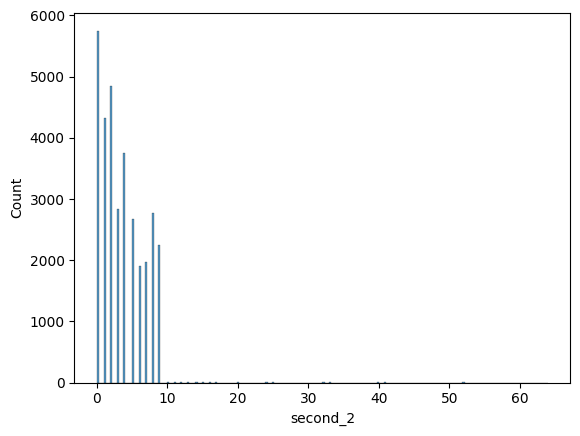

In [50]:
df_num['second_2'] = df_num['second_2'].astype(int)
sns.histplot(data=df_num, x='second_2')

In [51]:
df_num['second_2'] = df_num['second_2'].apply(lambda x: np.nan if x>9 else x)

In [52]:
df_num_seccheck = df_num[~pd.isna(df_num['second_1'])]
df_num_seccheck = df_num_seccheck[~pd.isna(df_num_seccheck['second_2'])]
df_num_seccheck['second'] = df_num_seccheck['second_1'].astype(int).astype(str) + df_num_seccheck['second_2'].astype(int).astype(str)
df_num_seccheck['second'] = df_num_seccheck['second'].astype(int)
df_num_seccheck['second'] = df_num_seccheck['second'].apply(lambda x: np.nan if x>59 else x)
df_num_nullsec = df_num.loc[pd.isna(df_num['second_1']) | pd.isna(df_num['second_2'])]
df_num_nullsec = df_num_nullsec.copy(deep=True)
df_num_nullsec['second'] = np.nan
df_num = pd.concat([df_num_seccheck, df_num_nullsec])
print(len(df_num))
df_num[['second', 'second_1', 'second_2']].sample(10)

33178


,second,second_1,second_2
112984,13.0,1.0,3.0
44291,43.0,4.0,3.0
53804,13.0,1.0,3.0
96287,55.0,5.0,5.0
109198,10.0,1.0,0.0
119017,19.0,1.0,9.0
92713,9.0,0.0,9.0
54871,12.0,1.0,2.0
90405,31.0,3.0,1.0
111952,24.0,2.0,4.0


construct timestamp:

In [53]:
df_num = construct_timestamp(df_in=df_num)
print(len(df_num))

33178


In [54]:
df_num[['year', 'month', 'day', 'hour', 'minute', 'second', 'Timestamp', 'time_quality']].sample(10)

,year,month,day,hour,minute,second,Timestamp,time_quality
99760,1967.0,03,31,3.0,16.0,17.0,1967-03-31 03:16:17,1
114291,1966.0,03,05,3.0,43.0,24.0,1966-03-05 03:43:24,1
120456,1965.0,10,31,17.0,21.0,0.0,1965-10-31 17:21:00,1
111335,1965.0,10,03,5.0,56.0,18.0,1965-10-03 05:56:18,1
91740,1966.0,06,01,21.0,44.0,24.0,1966-06-01 21:44:24,1
114533,1966.0,03,31,8.0,47.0,25.0,1966-03-31 08:47:25,1
102517,1967.0,03,14,6.0,37.0,46.0,1967-03-14 06:37:46,1
97912,1967.0,01,20,14.0,9.0,22.0,1967-01-20 14:09:22,1
101673,1966.0,07,12,0.0,42.0,50.0,1966-07-12 00:42:50,1
94352,1966.0,09,13,17.0,36.0,53.0,1966-09-13 17:36:53,1


#  

#### dot - check timestamp components, construct timestamp:

In [55]:
df_dot = df_dot.copy(deep=True)
df_dot[['year_1', 'day_1', 'day_2', 'day_3', 'hour_1', 'hour_2', 'minute_1', 'minute_2', 'second_1', 'second_2', 'is_dot']].sample(10)

,year_1,day_1,day_2,day_3,hour_1,hour_2,minute_1,minute_2,second_1,second_2,is_dot
95287,NaN,8.0,0.0,0.0,9.0,0.0,8.0,8.0,1.0,8.0,NaN
110344,NaN,1.0,8.0,0.0,1.0,8.0,8.0,0.0,16.0,8.0,NaN
110373,NaN,1.0,16.0,8.0,16.0,9.0,8.0,16.0,0.0,17.0,NaN
107770,NaN,1.0,12.0,4.0,4.0,0.0,13.0,8.0,8.0,8.0,NaN
107584,NaN,1.0,4.0,4.0,4.0,0.0,9.0,0.0,13.0,1.0,NaN
110876,NaN,1.0,8.0,8.0,17.0,0.0,8.0,8.0,9.0,8.0,NaN
95197,NaN,1.0,8.0,1.0,8.0,1.0,1.0,13.0,4.0,0.0,NaN
108174,NaN,8.0,0.0,0.0,8.0,8.0,8.0,8.0,1.0,8.0,NaN
110999,NaN,1.0,8.0,0.0,1.0,8.0,8.0,8.0,8.0,8.0,NaN
109945,NaN,1.0,8.0,8.0,0.0,0.0,24.0,1.0,33.0,1.0,NaN


day:

<Axes: xlabel='day_1', ylabel='Count'>

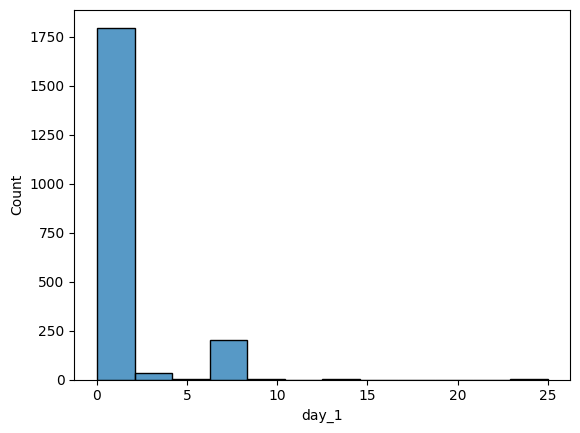

In [56]:
df_dot['day_1'] = df_dot['day_1'].astype(int)
sns.histplot(data=df_dot, x='day_1')

In [57]:
df_dot['day_1'] = df_dot['day_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='day_2', ylabel='Count'>

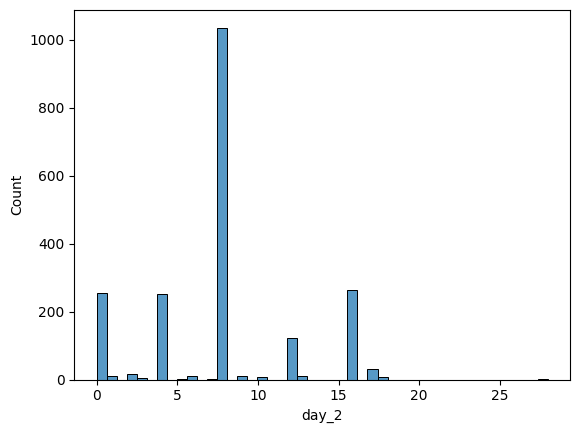

In [58]:
df_dot['day_2'] = df_dot['day_2'].astype(int)
sns.histplot(data=df_dot, x='day_2')

In [59]:
df_dot['day_2'] = df_dot['day_2'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='day_3', ylabel='Count'>

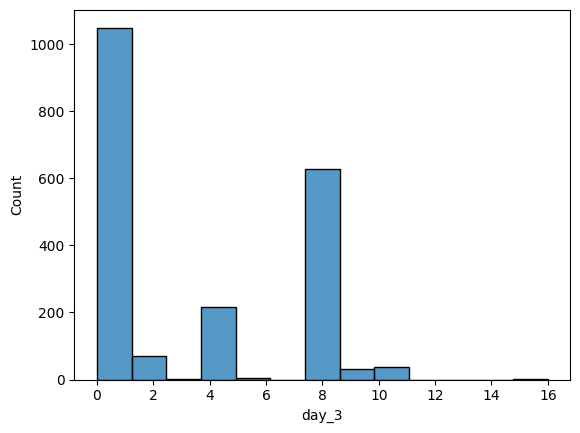

In [60]:
df_dot['day_3'] = df_dot['day_3'].astype(int)
sns.histplot(data=df_dot, x='day_3')

In [61]:
df_dot['day_3'] = df_dot['day_3'].apply(lambda x: np.nan if x>9 else x)

In [62]:
df_dot_daycheck = df_dot[~pd.isna(df_dot['day_1'])]
df_dot_daycheck = df_dot_daycheck[~pd.isna(df_dot_daycheck['day_2'])]
df_dot_daycheck = df_dot_daycheck[~pd.isna(df_dot_daycheck['day_3'])]
df_dot_daycheck['day_of_year'] = df_dot_daycheck['day_1'].astype(int).astype(str) + df_dot_daycheck['day_2'].astype(int).astype(str) + df_dot_daycheck['day_3'].astype(int).astype(str)
df_dot_daycheck['day_of_year'] = df_dot_daycheck['day_of_year'].astype(int)
df_dot_daycheck['day_of_year'] = df_dot_daycheck['day_of_year'].apply(lambda x: np.nan if x>366 else x)
df_dot_daycheck['day_of_year'] = df_dot_daycheck['day_of_year'].apply(lambda x: np.nan if x==0 else x)
df_dot_nullday = df_dot.loc[pd.isna(df_dot['day_1']) | pd.isna(df_dot['day_2']) | pd.isna(df_dot['day_3'])]
df_dot_nullday = df_dot_nullday.copy(deep=True)
df_dot_nullday['day_of_year'] = np.nan
df_dot = pd.concat([df_dot_daycheck, df_dot_nullday])
print(len(df_dot))
df_dot[['day_of_year', 'day_1', 'day_2', 'day_3']].sample(10)

2042


,day_of_year,day_1,day_2,day_3
108012,188.0,1.0,8.0,8.0
110173,NaN,1.0,NaN,8.0
107726,NaN,1.0,NaN,8.0
109787,NaN,1.0,NaN,8.0
111078,NaN,1.0,NaN,8.0
95114,282.0,2.0,8.0,2.0
109863,188.0,1.0,8.0,8.0
107622,NaN,1.0,NaN,4.0
109843,NaN,1.0,NaN,8.0
108838,280.0,2.0,8.0,0.0


year - infer from day:

In [63]:
df_dot['year'] = np.nan
for i in range(0, len(df_dot)):
    day = df_dot['day_of_year'].iloc[i]
    if (day < 366) & (day > 0):
        if day > 271:
            df_dot['year'].iloc[i] = 1962
        else:
            df_dot['year'].iloc[i] = 1963
df_dot[['year', 'day_of_year', 'day_1', 'day_2', 'day_3']].sample(10)

C:\Users\rnaidoo\AppData\Local\Temp\ipykernel_6072\2722169012.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dot['year'].iloc[i] = 1962
C:\Users\rnaidoo\AppData\Local\Temp\ipykernel_6072\2722169012.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dot['year'].iloc[i] = 1963


,year,day_of_year,day_1,day_2,day_3
107617,1963.0,144.0,1.0,4.0,4.0
95207,NaN,NaN,8.0,0.0,0.0
107954,1963.0,148.0,1.0,4.0,8.0
107922,NaN,NaN,1.0,NaN,8.0
108037,1963.0,140.0,1.0,4.0,0.0
111145,1963.0,140.0,1.0,4.0,0.0
110246,1963.0,180.0,1.0,8.0,0.0
107723,1963.0,144.0,1.0,4.0,4.0
111033,1963.0,140.0,1.0,4.0,0.0
108682,NaN,NaN,NaN,0.0,0.0


hour:

<Axes: xlabel='hour_1', ylabel='Count'>

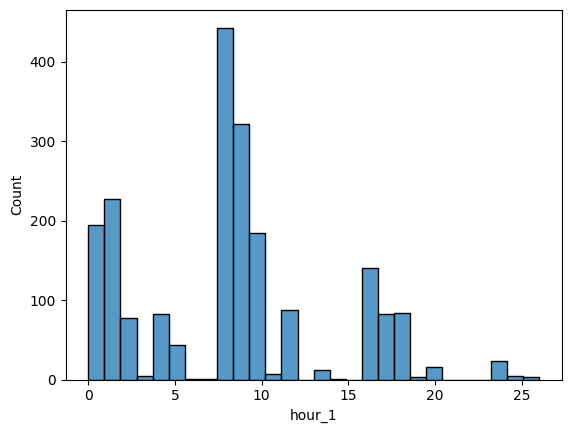

In [64]:
df_dot['hour_1'] = df_dot['hour_1'].astype(int)
sns.histplot(data=df_dot, x='hour_1')

In [65]:
df_dot['hour_1'] = df_dot['hour_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='hour_2', ylabel='Count'>

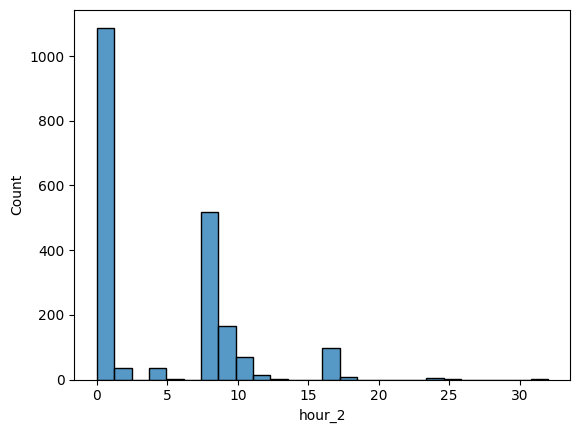

In [66]:
df_dot['hour_2'] = df_dot['hour_2'].astype(int)
sns.histplot(data=df_dot, x='hour_2')

In [67]:
df_dot['hour_2'] = df_dot['hour_2'].apply(lambda x: np.nan if x>9 else x)

In [68]:
df_dot_hourcheck = df_dot[~pd.isna(df_dot['hour_1'])]
df_dot_hourcheck = df_dot_hourcheck[~pd.isna(df_dot_hourcheck['hour_2'])]
df_dot_hourcheck['hour'] = df_dot_hourcheck['hour_1'].astype(int).astype(str) + df_dot_hourcheck['hour_2'].astype(int).astype(str)
df_dot_hourcheck['hour'] = df_dot_hourcheck['hour'].astype(int)
df_dot_hourcheck['hour'] = df_dot_hourcheck['hour'].apply(lambda x: np.nan if x>23 else x)
df_dot_nullhour = df_dot.loc[pd.isna(df_dot['hour_1']) | pd.isna(df_dot['hour_2'])]
df_dot_nullhour = df_dot_nullhour.copy(deep=True)
df_dot_nullhour['hour'] = np.nan
df_dot = pd.concat([df_dot_hourcheck, df_dot_nullhour])
print(len(df_dot))
df_dot[['hour', 'hour_1', 'hour_2']].sample(10)

2042


,hour,hour_1,hour_2
108772,NaN,NaN,1.0
111090,1.0,0.0,1.0
111143,NaN,8.0,8.0
109946,NaN,8.0,1.0
110291,NaN,8.0,8.0
112373,NaN,8.0,4.0
108615,NaN,NaN,0.0
108832,NaN,9.0,1.0
110203,NaN,9.0,1.0
108164,NaN,NaN,0.0


minute:

<Axes: xlabel='minute_1', ylabel='Count'>

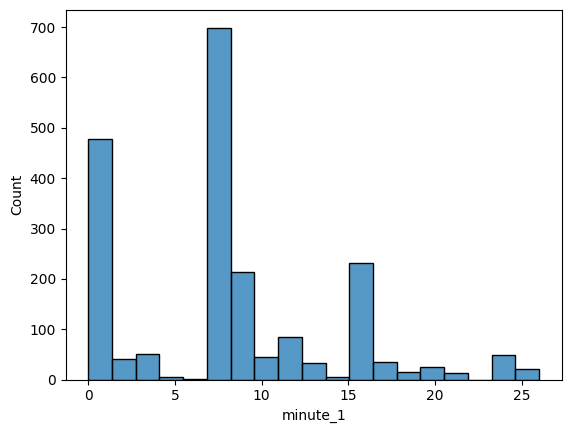

In [69]:
df_dot['minute_1'] = df_dot['minute_1'].astype(int)
sns.histplot(data=df_dot, x='minute_1')

In [70]:
df_dot['minute_1'] = df_dot['minute_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='minute_2', ylabel='Count'>

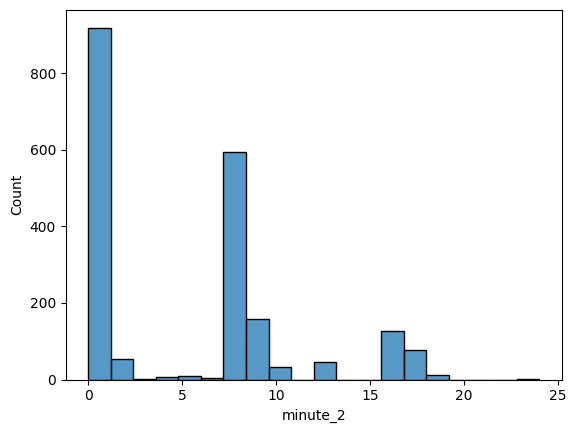

In [71]:
df_dot['minute_2'] = df_dot['minute_2'].astype(int)
sns.histplot(data=df_dot, x='minute_2')

In [72]:
df_dot['minute_2'] = df_dot['minute_2'].apply(lambda x: np.nan if x>9 else x)

In [73]:
df_dot_mincheck = df_dot[~pd.isna(df_dot['minute_1'])]
df_dot_mincheck = df_dot_mincheck[~pd.isna(df_dot_mincheck['minute_2'])]
df_dot_mincheck['minute'] = df_dot_mincheck['minute_1'].astype(int).astype(str) + df_dot_mincheck['minute_2'].astype(int).astype(str)
df_dot_mincheck['minute'] = df_dot_mincheck['minute'].astype(int)
df_dot_mincheck['minute'] = df_dot_mincheck['minute'].apply(lambda x: np.nan if x>59 else x)
df_dot_nullmin = df_dot.loc[pd.isna(df_dot['minute_1']) | pd.isna(df_dot['minute_2'])]
df_dot_nullmin = df_dot_nullmin.copy(deep=True)
df_dot_nullmin['minute'] = np.nan
df_dot = pd.concat([df_dot_mincheck, df_dot_nullmin])
print(len(df_dot))
df_dot[['minute', 'minute_1', 'minute_2']].sample(10)

2042


,minute,minute_1,minute_2
107755,NaN,2.0,NaN
112379,NaN,9.0,8.0
110946,NaN,NaN,NaN
107882,NaN,8.0,NaN
110158,10.0,1.0,0.0
108636,NaN,8.0,0.0
107578,NaN,NaN,0.0
108833,NaN,8.0,8.0
110250,0.0,0.0,0.0
109829,NaN,NaN,8.0


second:

<Axes: xlabel='second_1', ylabel='Count'>

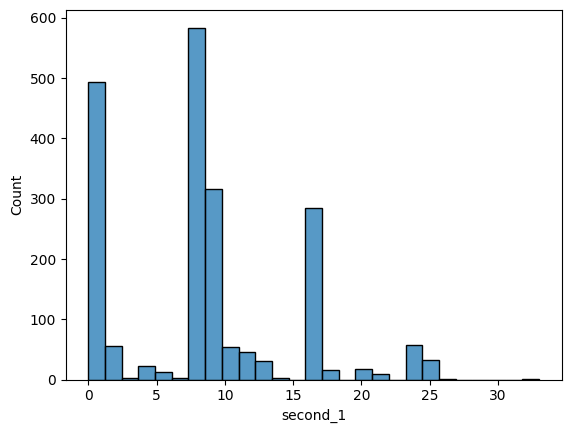

In [74]:
df_dot['second_1'] = df_dot['second_1'].astype(int)
sns.histplot(data=df_dot, x='second_1')

In [75]:
df_dot['second_1'] = df_dot['second_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='second_2', ylabel='Count'>

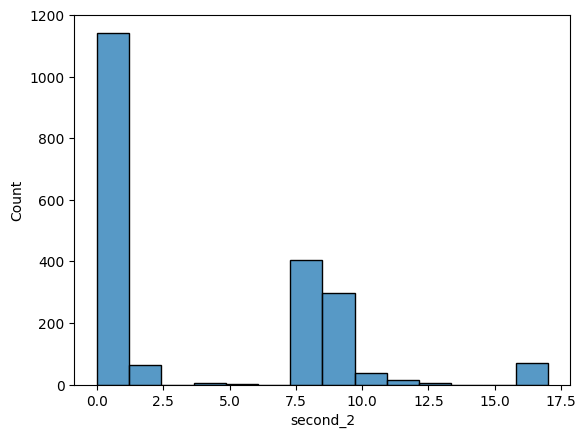

In [76]:
df_dot['second_2'] = df_dot['second_2'].astype(int)
sns.histplot(data=df_dot, x='second_2')

In [77]:
df_dot['second_2'] = df_dot['second_2'].apply(lambda x: np.nan if x>9 else x)

In [78]:
df_dot_seccheck = df_dot[~pd.isna(df_dot['second_1'])]
df_dot_seccheck = df_dot_seccheck[~pd.isna(df_dot_seccheck['second_2'])]
df_dot_seccheck['second'] = df_dot_seccheck['second_1'].astype(int).astype(str) + df_dot_seccheck['second_2'].astype(int).astype(str)
df_dot_seccheck['second'] = df_dot_seccheck['second'].astype(int)
df_dot_seccheck['second'] = df_dot_seccheck['second'].apply(lambda x: np.nan if x>59 else x)
df_dot_nullsec = df_dot.loc[pd.isna(df_dot['second_1']) | pd.isna(df_dot['second_2'])]
df_dot_nullsec = df_dot_nullsec.copy(deep=True)
df_dot_nullsec['second'] = np.nan
df_dot = pd.concat([df_dot_seccheck, df_dot_nullsec])
print(len(df_dot))
df_dot[['second', 'second_1', 'second_2']].sample(10)

2042


,second,second_1,second_2
109808,NaN,8.0,0.0
107515,NaN,9.0,8.0
111058,NaN,8.0,0.0
108734,NaN,NaN,0.0
107904,10.0,1.0,0.0
111149,NaN,8.0,8.0
107669,NaN,NaN,9.0
108672,NaN,NaN,1.0
95310,NaN,9.0,1.0
107524,40.0,4.0,0.0


construct timestamp:

In [79]:
df_dot = construct_timestamp(df_in=df_dot)
print(len(df_dot))

2042


In [80]:
df_dot[['year', 'month', 'day', 'hour', 'minute', 'second', 'Timestamp', 'time_quality']].sample(10)

,year,month,day,hour,minute,second,Timestamp,time_quality
95161,NaN,NaN,NaN,20.0,NaN,NaN,NaT,0
110895,1963.0,06,29,NaN,NaN,1.0,1963-06-29 00:00:00,4
95312,1962.0,10,07,10.0,NaN,NaN,1962-10-07 10:00:00,3
108843,1963.0,06,29,NaN,NaN,19.0,1963-06-29 00:00:00,4
110248,1963.0,06,29,NaN,0.0,NaN,1963-06-29 00:00:00,4
107637,1963.0,05,28,NaN,NaN,NaN,1963-05-28 00:00:00,4
109806,1963.0,05,20,10.0,NaN,NaN,1963-05-20 10:00:00,3
109885,NaN,NaN,NaN,NaN,NaN,NaN,NaT,0
109773,NaN,NaN,NaN,18.0,NaN,NaN,NaT,0
107510,1963.0,05,24,NaN,58.0,NaN,1963-05-24 00:00:00,4


#  

#### Check station number:

num2:

<Axes: xlabel='station_number_OCR', ylabel='Count'>

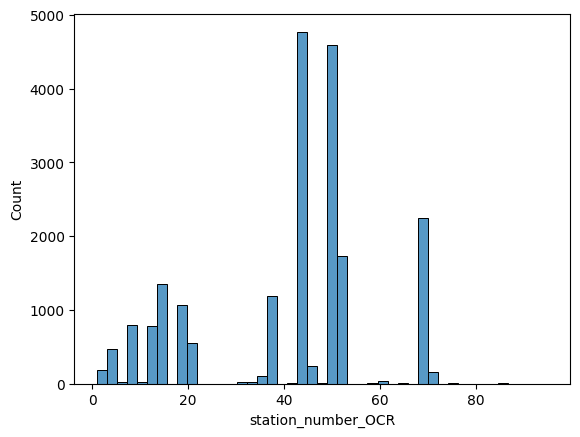

In [81]:
df_num2['station_number_OCR'] = df_num2['station_number_OCR'].astype('float')
sns.histplot(data=df_num2, x='station_number_OCR')

In [82]:
df_num2['station_number'] = df_num2['station_number_OCR']
df_num2[['station_number', 'station_number_OCR']].sample(10)

,station_number,station_number_OCR
60041,43.0,43.0
23929,69.0,69.0
72114,12.0,12.0
8091,50.0,50.0
76958,53.0,53.0
23277,69.0,69.0
58221,43.0,43.0
63227,15.0,15.0
67962,53.0,53.0
83185,50.0,50.0


num:

<Axes: xlabel='station_number_1', ylabel='Count'>

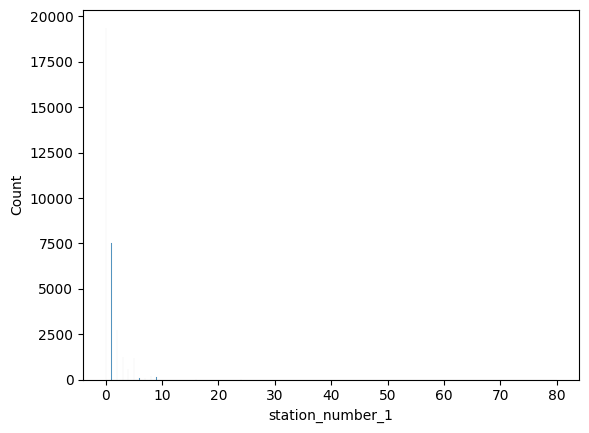

In [83]:
df_num['station_number_1'] = df_num['station_number_1'].astype(int)
sns.histplot(data=df_num, x='station_number_1')

In [84]:
df_num['station_number_1'] = df_num['station_number_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='station_number_2', ylabel='Count'>

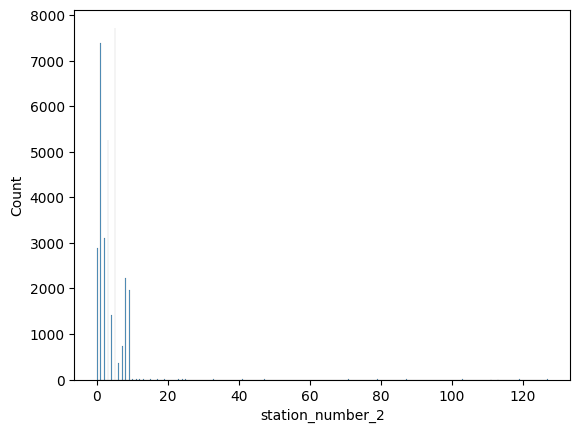

In [85]:
df_num['station_number_2'] = df_num['station_number_2'].astype(int)
sns.histplot(data=df_num, x='station_number_2')

In [86]:
df_num['station_number_2'] = df_num['station_number_2'].apply(lambda x: np.nan if x>9 else x)

In [87]:
df_num_stncheck = df_num[~pd.isna(df_num['station_number_1'])]
df_num_stncheck = df_num_stncheck[~pd.isna(df_num_stncheck['station_number_2'])]
df_num_stncheck['station_number'] = df_num_stncheck['station_number_1'].astype(int).astype(str) + df_num_stncheck['station_number_2'].astype(int).astype(str)
df_num_stncheck['station_number'] = df_num_stncheck['station_number'].astype(int)
df_num_nullstn = df_num.loc[pd.isna(df_num['station_number_1']) | pd.isna(df_num['station_number_2'])]
df_num_nullstn = df_num_nullstn.copy(deep=True)
df_num_nullstn['station_number'] = np.nan
df_num = pd.concat([df_num_stncheck, df_num_nullstn])
print(len(df_num))
df_num[['station_number', 'station_number_1', 'station_number_2']].sample(10)

33178


,station_number,station_number_1,station_number_2
119645,13.0,1.0,3.0
114152,5.0,0.0,5.0
118148,13.0,1.0,3.0
105384,19.0,1.0,9.0
104991,13.0,1.0,3.0
77927,13.0,1.0,3.0
90448,3.0,0.0,3.0
29182,22.0,2.0,2.0
113088,1.0,0.0,1.0
91468,4.0,0.0,4.0


dot:

In [88]:
df_dot[['station_number']].sample(10)

,station_number
109782,1.0
108069,9.0
110328,8.0
107967,1.0
95191,18.0
108619,25.0
109786,17.0
108728,1.0
111118,8.0
110964,0.0


#  

#### Recombine results, save:

In [89]:
df_result2 = pd.concat([df_num2, df_num, df_dot, df_outlier, df_loss])
print(len(df_result2))
df_result2.sample(10)

126332


,Directory,Subdirectory,filename,processed_image_class,fmin,max_depth,station_number,station_number_1,station_number_2,year_1,...,year,day_of_year,hour,minute,second,time_quality,month_day,month,day,Timestamp
109691,R014207961,1047,70.png,num,1.504032,1133.333333,9.0,0.0,9.0,3.0,...,1965.0,286.0,10.0,38.0,22.0,1.0,10-13,10,13,1965-10-13 10:38:22
96575,R014207944,2027-13B,90.png,num,1.556452,1336.538462,30.0,3.0,0.0,2.0,...,1964.0,NaN,20.0,NaN,NaN,0.0,NaN,NaN,NaN,NaT
119581,R014207969,1282-13B,186.png,num,1.504032,811.538462,13.0,1.0,3.0,3.0,...,1965.0,243.0,9.0,32.0,30.0,1.0,08-31,08,31,1965-08-31 09:32:30
81165,R014207839,4105-43A,286.png,loss,1.528226,1252.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
121331,R014207969,1324-5A,306.png,num,1.500000,1454.166667,5.0,0.0,5.0,3.0,...,1965.0,325.0,16.0,46.0,28.0,1.0,11-21,11,21,1965-11-21 16:46:28
60889,R014207831,3949-5A,4.png,loss,2.131579,1404.347826,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
98090,R014207945,2254-5A,178.png,loss,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
6977,R014207808,4601-69,18.png,loss,2.185484,1384.313725,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
47027,R014207828,4391-50A,100.png,loss,1.608871,906.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
12254,R014207810,5137,311.png,loss,3.830189,1200.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


Save:

In [90]:
df_result2.to_csv(resultDir + 'result_postprocess_raw.csv', index=False)

#  

#### Retrieve station details:

In [91]:
df_stn_nums = pd.read_excel(logDir + 'station_number_changes.xlsx')
df_stn_nums.head()

,Station_Number,Station_Code,Station_Name,Start_Date,Notes
0,1,RES,"Resolute Bay, NT, Canada",1962-09-29,Assumed start date at launch.
1,1,BPT,"Blossom Point, MD, USA",1965-07-01,NaN
2,2,PRI,"Prince Albert, SK, Canada",1962-09-29,Assumed start date at launch.
3,3,OTT,"Ottawa, Canada",1962-09-29,Assumed start date at launch.
4,3,FTM,"Fort Myers, FL, USA",1965-07-01,NaN


In [92]:
change_dates = df_stn_nums['Start_Date'].drop_duplicates().sort_values().reset_index(drop=True)
stn_nums = df_stn_nums['Station_Number'].unique()

In [93]:
#df_result_pp = pd.read_csv(resultDir + 'result_postprocess_raw.csv')
df_result2 = df_result2.loc[~pd.isna(df_result2['station_number'])]

In [94]:
df_result3 = pd.DataFrame()
for i in range(0, len(change_dates)):
    #Before the first change date - Assume there are no station numbers before launch
    if i == 0:
        print(change_dates[i])
        df_part = df_result2.loc[df_result2['Timestamp'] < change_dates[i]]
        df_result3 = pd.concat([df_result3, df_part])
        print(len(df_result3))
    
    elif i > 0:
        print(change_dates[i])
        df_part_ = df_result2.loc[df_result2['Timestamp'] < change_dates[i]]
        df_part_ = df_part_.loc[df_part_['Timestamp'] >= change_dates[i-1]]
        
        df_sns = pd.DataFrame()
        for sn in stn_nums:
            df_sn = df_stn_nums.loc[df_stn_nums['Station_Number'] == sn]
            df_sn = df_sn.loc[df_sn['Start_Date'] < change_dates[i]]
            if len(df_sn) > 1:
                df_sn = df_sn.sort_values('Start_Date', ascending=False)
                df_sn = df_sn.iloc[:1]
            df_sns = pd.concat([df_sns, df_sn])
        
        df_part = df_part_.merge(df_sns[['Station_Number', 'Station_Code']], how='left', left_on='station_number', right_on='Station_Number')
        df_result3 = pd.concat([df_result3, df_part])
        print(len(df_result3))

#After last change date
last_change_date = change_dates[len(change_dates)-1]
print('After ' + str(last_change_date))
df_part_ = df_result2.loc[df_result2['Timestamp'] > last_change_date]

df_sns = pd.DataFrame()
for sn in stn_nums:
    df_sn = df_stn_nums.loc[df_stn_nums['Station_Number'] == sn]
    if len(df_sn) > 1:
        df_sn = df_sn.sort_values('Start_Date', ascending=False)
        df_sn = df_sn.iloc[:1]
    df_sns = pd.concat([df_sns, df_sn])

df_part = df_part_.merge(df_sns[['Station_Number', 'Station_Code']], how='left', left_on='station_number', right_on='Station_Number')
df_result3 = pd.concat([df_result3, df_part])
print(len(df_result3))

1962-09-29 00:00:00
1869
1963-04-25 00:00:00
4059
1963-08-06 00:00:00
5759
1965-07-01 00:00:00
9027
After 1965-07-01 00:00:00
48125


In [95]:
df_stns = pd.read_csv(logDir + 'ground_stations.csv')
df_stns.head()

,Station_Code,Station_Name,Lat,Lng,Notes
0,ANT,"Antofagasta, Chile",23.6S,70.3W,NaN
1,BAT,"Byrd Station, Antarctica",80S,119.3W,Ref: https://en.wikipedia.org/wiki/Byrd_Station
2,BFR,"Bretigny, France",48.4N,2.2 E,Ref: https://en.wikipedia.org/wiki/Br%C3%A9tig...
3,BLR,"Boulder, CO, USA",40.1N,105.1W,NaN
4,BPT,"Blossom Point, MD, USA",38.4N,77.1W,NaN


In [96]:
df_result4 = df_result3.merge(df_stns[['Station_Code', 'Station_Name', 'Lat', 'Lng']], how='left', on='Station_Code')
print(len(df_result4))
df_result4[['Station_Number', 'Timestamp', 'Station_Code', 'Station_Name', 'Lat', 'Lng']].sample(10)

48125


,Station_Number,Timestamp,Station_Code,Station_Name,Lat,Lng
33597,5.0,1967-02-15 03:48:46,QUI,"Quito, Ecuador",0.6S,78.6W
46668,5.0,1965-11-09 15:48:10,QUI,"Quito, Ecuador",0.6S,78.6W
25073,50.0,1967-10-11 13:57:15,OTT,"Ottawa, Canada",45.4N,75.7W
29149,1.0,1966-09-13 01:53:44,BPT,"Blossom Point, MD, USA",38.4N,77.1W
2693,12.0,1963-04-22 21:31:11,WOO,"Woomera, Australia",31.1S,136.8E
47328,NaN,1966-05-11 15:50:00,NaN,NaN,NaN,NaN
46888,5.0,1965-12-09 16:47:05,QUI,"Quito, Ecuador",0.6S,78.6W
39822,7.0,1965-10-19 13:02:45,QUI,"Quito, Ecuador",0.6S,78.6W
45984,13.0,1965-09-21 20:30:53,COL,"College, Fairbanks, AK, USA",64.9N,147.8W
35149,5.0,1967-03-18 00:11:49,QUI,"Quito, Ecuador",0.6S,78.6W


#  

#### Save Master:

In [97]:
df_result5 = df_result4[~pd.isna(df_result4['Station_Code'])]
df_result5 = df_result5[['Directory', 'Subdirectory', 'filename', 'processed_image_class', 'fmin', 'max_depth', 'Timestamp',
                         'time_quality', 'Station_Number', 'Station_Code', 'Station_Name', 'Lat', 'Lng']]
print(len(df_result5))
df_result5.sample(10)

42951


,Directory,Subdirectory,filename,processed_image_class,fmin,max_depth,Timestamp,time_quality,Station_Number,Station_Code,Station_Name,Lat,Lng
12125,R014207818,4242-38A,197.png,num2,1.629032,1014.000000,1967-07-23 12:40:56,1.0,38.0,SOL,Falkland Islands (Islas Malvinas),51.8S,57.9W
36966,R014207952,2708-13B,220.png,num,1.705645,1069.811321,1967-04-09 17:13:17,1.0,13.0,COL,"College, Fairbanks, AK, USA",64.9N,147.8W
29795,R014207944,1998-5B,53.png,num,1.504032,1417.647059,1966-09-12 02:54:27,1.0,5.0,QUI,"Quito, Ecuador",0.6S,78.6W
24550,R014207839,4124-50A,58.png,num2,1.641129,1044.897959,1967-08-26 08:44:49,1.0,50.0,OTT,"Ottawa, Canada",45.4N,75.7W
41158,R014207963,1531-5A,256.png,num,1.770161,1434.615385,1966-03-13 03:25:28,1.0,5.0,QUI,"Quito, Ecuador",0.6S,78.6W
16574,R014207831,3943-43A,225.png,num2,1.674603,1334.782609,1967-04-27 16:07:42,1.0,43.0,RES,"Resolute Bay, NT, Canada",74.7N,95W
30819,R014207944,2037-13B,158.png,num,1.689516,1286.538462,1966-10-02 18:39:31,1.0,13.0,COL,"College, Fairbanks, AK, USA",64.9N,147.8W
46999,R014207969,1326-18B,115.png,num,1.500000,1121.568627,1965-07-22 05:37:34,1.0,18.0,WOO,"Woomera, Australia",31.1S,136.8E
17462,R014207833,4357-50,150.png,num2,1.556452,950.000000,1967-12-08 18:43:47,1.0,50.0,OTT,"Ottawa, Canada",45.4N,75.7W
44178,R014207969,1268-13B,284.png,num,1.504032,667.307692,1965-07-28 14:57:31,1.0,13.0,COL,"College, Fairbanks, AK, USA",64.9N,147.8W


In [98]:
df_result5 = df_result5.sort_values('Timestamp').reset_index(drop=True)
df_result5.to_csv(resultDir + 'result_master.csv', index=False)